# Examples of all decoders (except Kalman Filter)

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data for use in all decoders
4. Run some example decoders and print the goodness of fit
5. Plot example decoded outputs

See "Examples_kf_decoder_hc" for a Kalman filter example. <br>
Because the Kalman filter utilizes different preprocessing, we don't include an example here (to keep this notebook more understandable)

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [1]:
## (Configuration) Allows you to return multiple variables from a single cell ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
## Allows you to import files from another folder in current directory ## 
import os 
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

# # For Neural Network Models
# from tensorflow import keras 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

 

In [14]:
folder='/Users/rbhatt6/Documents/MATLAB/' #ENTER THE FOLDER THAT YOUR DATA IS IN

# Opening Acc/Dec Data 
with open(folder+'sortInAccDec.pickle','rb') as f:
     sort_In=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutXAccDec.pickle','rb') as f:
     sort_Out_X=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDec.pickle','rb') as f:
     sort_Out_Y=pickle.load(f,encoding='latin1') 

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [3]:
bins_before=4 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=5 #How many bins of neural data after the output are used for decoding

In [5]:
# No Memory or Prediction Used 
bins_before=0 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

### 3B. Format Input Covariates

#### Example Hippo Data

In [7]:
#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0) #Total number of spikes of each neuron
rmv_nrn=np.where(nd_sum<100) #Find neurons who have less than 100 spikes total
neural_data=np.delete(neural_data,rmv_nrn,1) #Remove those neurons

In [11]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

X.shape
X_flat.shape

(28039, 1, 46)

(28039, 46)

#### Format Output Covariates

In [6]:
#Set decoding output
y=pos_binned

In [7]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1])) #Find time bins with no output
X=np.delete(X,rmv_time,0) #Remove those time bins from X
X_flat=np.delete(X_flat,rmv_time,0) #Remove those time bins from X_flat
y=np.delete(y,rmv_time,0) #Remove those time bins from y

### 3C. Split into training / testing / validation sets
Note that hyperparameters should be determined using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

#### User Options

In [17]:
training_range=[0, 0.8]
valid_range=[0.8,0.9]
testing_range=[0.9, 1]

len(sort_In)

16

In [39]:
# Training and Testing on X-Component and Y-Component

#X_Comp_R2s_Weiner =[]
#X_Comp_R2s_Weiner_Cascade =[]
Y_Comp_R2s_Weiner =[]
#Y_Comp_R2s_Weiner_Cascade =[]
model = "Wiener"

for i in range(len(sort_In)):
    curr_Sort_In = sort_In[i]
    curr_Sort_Out = sort_Out_Y[i]
    # currSortOutY = sortOutY[i]
    num_examples=curr_Sort_In.shape[0] # nRows (b/c nCols = number of units)

    #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
    testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

    #Get training data
    X_train=curr_Sort_In[training_set,:]
    y_train=curr_Sort_Out[training_set,:]

    #Get testing data
    X_test=curr_Sort_In[testing_set,:]
    y_test=curr_Sort_Out[testing_set,:]

    #Get validation data
    X_valid=curr_Sort_In[valid_set,:]
    y_valid=curr_Sort_Out[valid_set,:]

    #Z-score "X" inputs. 
    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)
    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
    X_valid=(X_valid-X_train_mean)/X_train_std

    #Zero-center outputs
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean
    y_valid=y_valid-y_train_mean

    if model == "Wiener":
        #Declare model
        model_wf=WienerFilterDecoder()

        #Fit model
        model_wf.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_wf=model_wf.predict(X_valid)

        #Get metric of fit
        R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
        #X_Comp_R2s_Weiner.append(R2s_wf)
        Y_Comp_R2s_Weiner.append(R2s_wf)
    
    elif model == "WienerCasade":
        #Declare model
        model_wc=WienerCascadeDecoder(degree=2)

        #Fit model
        model_wc.fit(X_train,y_train)

        #Get predictions
        y_valid_predicted_wc=model_wc.predict(X_valid)

        #Get metric of fit
        R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
        #X_Comp_R2s_Weiner_Cascade.append(R2s_wc)
        Y_Comp_R2s_Weiner_Cascade.append(R2s_wc)


In [65]:
# X_Comp_R2s_Weiner

# X_Comp_R2s_Weiner_Cascade

# Y_Comp_R2s_Weiner

# Y_Comp_R2s_Weiner_Cascade

In [67]:
# Cleaning R2 results

X_Comp_R2s_Weiner_Final = []
X_Comp_R2s_Weiner_Cascade_Final = []
Y_Comp_R2s_Weiner_Final = []
Y_Comp_R2s_Weiner_Cascade_Final = []

for i in range(len(X_Comp_R2s_Weiner)):
    X_Comp_R2s_Weiner_Final.append(X_Comp_R2s_Weiner[i][0])
    X_Comp_R2s_Weiner_Cascade_Final.append(X_Comp_R2s_Weiner_Cascade[i][0])
    Y_Comp_R2s_Weiner_Final.append(Y_Comp_R2s_Weiner[i][0])
    Y_Comp_R2s_Weiner_Cascade_Final.append(Y_Comp_R2s_Weiner_Cascade[i][0])
    
# np.array(X_Comp_R2s_Weiner_Final)
# np.array(X_Comp_R2s_Weiner_Cascade_Final)
# np.array(Y_Comp_R2s_Weiner_Final)
# np.array(Y_Comp_R2s_Weiner_Cascade_Final)

In [64]:
# Saving results in a matlab file 

from scipy.io import savemat
import numpy

L = [X_Comp_R2s_Weiner_Final, X_Comp_R2s_Weiner_Cascade_Final, Y_Comp_R2s_Weiner_Final, Y_Comp_R2s_Weiner_Cascade_Final]

FrameStack = np.empty((4,), dtype=object)
for i in range(len(L)):
    FrameStack[i] = L[i]

savemat("modelOutputs.mat", {"FrameStack":FrameStack})

Text(0.5, 1.0, 'Wiener Filter')

Text(0.5, 1.0, 'Wiener Cascade Filter')

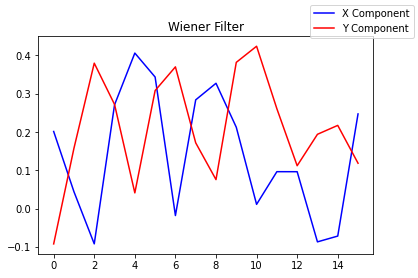

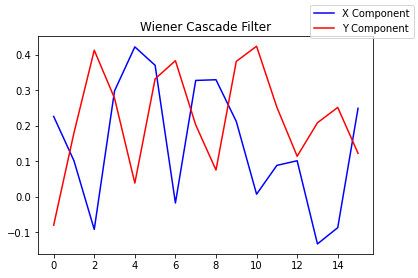

In [75]:
# Plot the results 

fig_Wiener = plt.figure()
plt.plot(X_Comp_R2s_Weiner_Final,'b')
plt.plot(Y_Comp_R2s_Weiner_Final, 'r')
fig_Wiener.legend(['X Component', 'Y Component'])
plt.title("Wiener Filter")

fig_Wiener_Casade = plt.figure()
plt.plot(X_Comp_R2s_Weiner_Cascade_Final,'b')
plt.plot(Y_Comp_R2s_Weiner_Cascade_Final, 'r')
fig_Wiener_Casade.legend(['X Component', 'Y Component'])
plt.title("Wiener Cascade Filter")

### 3D. Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

## 4. Run Decoders
In this example, we are evaluating the model fit on the validation set

**In this file, I only include some of the decoders. For examples of all the decoders, see the main example file (used with S1 data).**

### 4A. Wiener Filter (Linear Regression)

In [11]:
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)

#Get metric of fit
R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
print('R2s:', R2s_wf)

('R2s:', array([ 0.2607354 ,  0.32976491]))


### 4B. Wiener Cascade (Linear Nonlinear Model)

In [33]:
#Declare model
model_wc=WienerCascadeDecoder(degree=2)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

('R2s:', array([ 0.23998054,  0.34033074]))


### 4C. Dense (Feedfoward) Neural Network

In [42]:
#Declare model
model_dnn=DenseNNDecoder(units=100,dropout=0.25,num_epochs=10)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

('R2s:', array([ 0.42482215,  0.48195541]))


### 4D. LSTM

In [68]:
#Declare model
model_lstm=LSTMDecoder(units=100,dropout=.25,num_epochs=10)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

NameError: name 'Sequential' is not defined

## 5. Make Plots

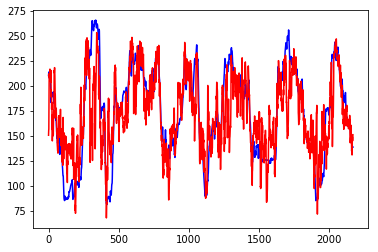

In [53]:
#As an example, I plot an example 3000 values of the x position (column index 0), both true and predicted with the Feedfoward neural network
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_dnn=plt.figure()
plt.plot(y_valid[2000:5000,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_dnn[2000:5000,0]+y_train_mean[0],'r')

#Save figure
# fig_x_dnn.savefig('x_position_decoding.eps')